In [1]:
import torch
from torch import nn as nn
import math
from glob import glob
from torchsummary import summary
from torch_snippets import *
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 

#is GPU available?
gpu = torch.cuda.is_available()

#defining device where to to the computation
device = torch.device(0) if gpu else torch.device('cpu')
device

device(type='cuda', index=0)

In [2]:
# Set the folder with the samples (images) that compose a dataset and the number of classes

orig_dir   = '..\Dataset\Compiled\Classification\Image'
nclasses   = 9

# Set the desired image size for rescaling and maximum value for normalization

width       = 341 
height      = 256
nchannels   = 3
maxval      = 255. 
input_shape = (nchannels,height,width)

# Set the percentages of samples that will be used for training, validation and test. 

train_perc = 0.40
valid_perc = 0.30
test_perc  = 0.30

# Create training, validation, and test sets.

data = glob(orig_dir+"/*.jpg") # it returns a list of image filenames

num_train_samples = int(len(data)*train_perc)
num_valid_samples = int(len(data)*valid_perc)  
num_test_samples  = int(len(data)*test_perc)
np.random.shuffle(data) # randomly change the order of the filenames in data
trainset = data[:num_train_samples] 
validset = data[num_train_samples:num_train_samples+num_valid_samples]
testset  = data[num_train_samples+num_valid_samples:]

# Set output model name

model_name  = 'FishCNN.pth'

In [3]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized, 
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters. 

prep = transforms.Compose([
    transforms.Resize((height,width), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Such transformations are applied everytime images are loaded from the filename lists in training, validation, 
# and test sets. We will do that during training, then by adding affine transformations and increasing the number 
# of epochs, we are actually implementing data augmentation. 

aug = transforms.Compose([
    transforms.Resize((400,400), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR, 
                            fill=0),
    transforms.CenterCrop(350),
    transforms.Resize((height,width), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Create an image dataset by applying one of the preprocessing transformations above

class ImageDataset(): # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset, transform=None):
        # it gets the image true labels and set the preprocessing transformation
        self.dataset   = dataset
        self.targets   = [int(str(x).split("\\")[-1].split("_")[0]) for x in self.dataset]
        self.transform = transform
    def __len__(self): return len(self.dataset)        
    def __getitem__(self, ix): # returns the item at position ix 
        filename = self.dataset[ix]
        target   = self.targets[ix]
        image    = Image.open(filename) # It is a PIL image
        if (self.transform is not None):
            image = self.transform(image)
        else: # just reshape the image as a tensor with nchannels, height, width
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float()                  
        return(image,target) 

In [4]:
trainset = ImageDataset(trainset, aug) # verify the difference with and wothout data augmentation
validset = ImageDataset(validset, prep)
testset  = ImageDataset(testset, prep)

Number of images: 172

Images are 341x256x3

Class of the image:  3

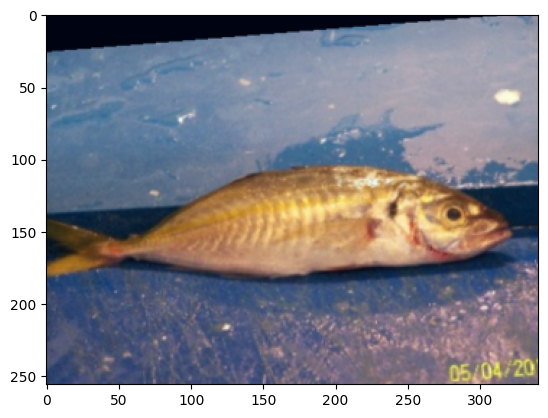

In [5]:
# visualize images from the trainset

print("Number of images:", len(trainset))
image, target = trainset[10] # it executes getitem
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
print("Class of the image: ", target+1)
plt.show()

In [6]:
batchsize = 10
trainload = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testload  = DataLoader(testset, batch_size=batchsize, shuffle=True)
validload = DataLoader(validset, batch_size=batchsize, shuffle=True)

inspect(next(iter(trainload))) # inspect a couple of items in the batches

══════════════════════════════════════════════════════════════════

list of 2 items

Tensor  Shape: torch.Size([10, 3, 256, 341])    Min: -2.118     Max: 2.640      Mean: -0.200    dtype: 
torch.float32 @ cpu

Tensor  Shape: torch.Size([10]) Min: 0.000      Max: 7.000      Mean: 3.700     dtype: torch.int64 @ cpu

══════════════════════════════════════════════════════════════════

In [7]:
def Criterion(preds, targets):
    ce            = nn.CrossEntropyLoss().to(device)
    loss          = ce(preds, targets.long()) 
    # compute mean accuracy in the batch
    pred_labels   = torch.max(preds, 1)[1] # same as argmax
    acc           = torch.sum(pred_labels == targets.data) / pred_labels.size(0)
    return loss, acc

def conv_block(nchannels_in, nchannels_out, stride_val):
    return nn.Sequential(
        #defining convolutional layer 
        nn.Conv2d(in_channels=nchannels_in, out_channels=nchannels_out, kernel_size=(3, 3),
                  stride=1, padding=1, bias=False),
        #defining a batch normalization layer
        nn.BatchNorm2d(num_features=nchannels_out),
        #defining activation layer
        nn.ReLU(),
        #defining a pooling layer
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )

class FishNet(nn.Module):

    def __init__(self, num_classes):
        super(FishNet, self).__init__()
        
        #define the first conv_block
        self.conv1 = conv_block(3,16,1)
        
        #defining the second conv_block
        #Note that the number of input channels is 16
        #Note that the number of output channels is 32
        #Note that the stride is 2
        #output values tested: 16, 32, 64
        self.conv2 = conv_block(16,64,2)                      
        
        #defining classifier
        self.classifier = nn.Sequential(
            #defining linear layer
            #output values tested: 128, 256, 512
            nn.Linear(in_features=1400832, out_features=256, bias=True),
            #defining activation layer
            nn.ReLU(),
            # defining a dropout layer
            nn.Dropout(0.2),
            #defining linear layer as decision layer
            nn.Linear(256, num_classes) #Note that you do not need nn.Softmax in torch
        )

    def forward(self, x):
        #extracts features
        x      = self.conv1(x)
        x      = self.conv2(x)
        #transforms outputs into a 2D tensor
        x = torch.flatten(x, start_dim=1)

        #classifies features
        y = self.classifier(x)
  
        return y

In [8]:
model = FishNet(nclasses).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = Criterion
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

In [9]:
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(preds, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(preds, targets)
    return loss.item(), acc.item()       

In [10]:
# initializing variables
n_epochs = 100
log      = Report(n_epochs)

# starting training and validation
for ex in range(n_epochs):
    N = len(trainload)
    for bx, data in enumerate(trainload):
        loss, acc = train_batch(model, data, optimizer, criterion, device)
        #report results for the batch
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    N = len(validload)
    for bx, data in enumerate(validload):
        loss, acc = validate_batch(model, data, criterion, device)
        log.record((ex+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (ex+1)%2==0: log.report_avgs(ex+1)

EPOCH: 2.000  trn_loss: 78.160  val_acc: 0.388  trn_acc: 0.272  val_loss: 15.759  (12.34s - 604.64s remaining)
EPOCH: 4.000  trn_loss: 2.151  val_acc: 0.209  trn_acc: 0.206  val_loss: 1.955  (21.58s - 517.83s remaining)
EPOCH: 6.000  trn_loss: 2.029  val_acc: 0.234  trn_acc: 0.211  val_loss: 1.934  (30.85s - 483.28s remaining)
EPOCH: 8.000  trn_loss: 2.041  val_acc: 0.240  trn_acc: 0.178  val_loss: 1.939  (39.81s - 457.85s remaining)
EPOCH: 10.000  trn_loss: 2.168  val_acc: 0.264  trn_acc: 0.189  val_loss: 1.950  (48.85s - 439.65s remaining)
EPOCH: 12.000  trn_loss: 2.015  val_acc: 0.264  trn_acc: 0.272  val_loss: 1.930  (57.89s - 424.54s remaining)
EPOCH: 14.000  trn_loss: 2.166  val_acc: 0.132  trn_acc: 0.150  val_loss: 2.232  (66.92s - 411.08s remaining)
EPOCH: 16.000  trn_loss: 2.102  val_acc: 0.162  trn_acc: 0.189  val_loss: 2.195  (75.95s - 398.71s remaining)
EPOCH: 18.000  trn_loss: 2.144  val_acc: 0.162  trn_acc: 0.206  val_loss: 2.091  (84.95s - 387.00s remaining)
EPOCH: 20.00

100%|██████████| 201/201 [00:00<00:00, 3525.08it/s]


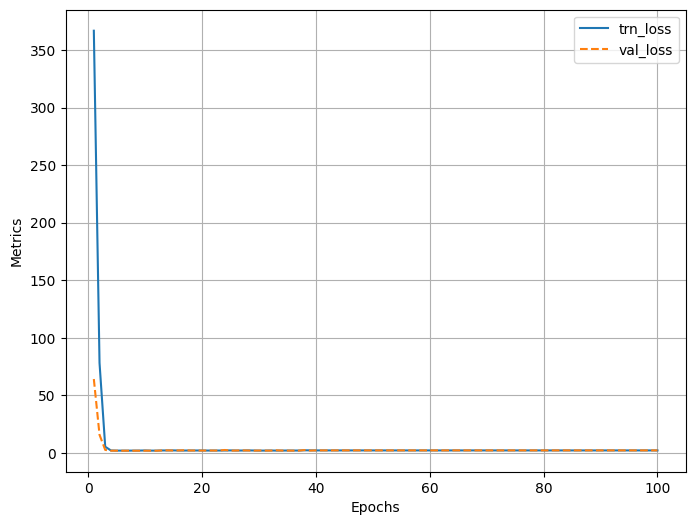

100%|██████████| 201/201 [00:00<00:00, 4487.87it/s]


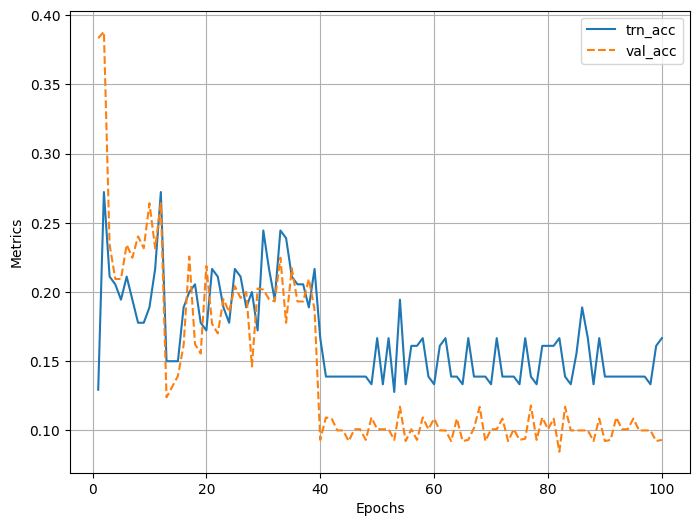

In [11]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])